In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
%matplotlib inline
sns.set(color_codes=True)

In [4]:
df=pd.read_csv('C:\\Users\\ASUS\\OneDrive\\Desktop\\bcg\\churn_data_modeling.csv')

In [5]:
df.head(1)

Unnamed: 0                                id  \
0           0  24011ae4ebbe3035111d65fa7c15bc57   

                      channel_sales  cons_12m  cons_gas_12m  cons_last_month  \
0  foosdfpfkusacimwkcsosbicdxkicaua         0         54946                0   

   date_activ    date_end date_modif_prod date_renewal  ...  \
0  2013-06-15  2016-06-15      2015-11-01   2015-06-23  ...   

   mean_year_price_off_peak_var  mean_year_price_peak_var  \
0                      0.131756                  0.092638   

   mean_year_price_mid_peak_var  mean_year_price_off_peak_fix  \
0                      0.036909                     42.497907   

   mean_year_price_peak_fix  mean_year_price_mid_peak_fix  \
0                 12.218665                      8.145777   

   mean_year_price_off_peak mean_year_price_peak  mean_year_price_med_peak  \
0                 42.629663            12.311304                  8.182687   

   churn  
0      1  

[1 rows x 54 columns]

In [6]:
df["date_activ"]= pd.to_datetime(df["date_activ"], format="%Y-%m-%d")
df["date_end"]= pd.to_datetime(df["date_end"], format="%Y-%m-%d")
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')
df.drop(df.columns[0], axis=1, inplace=True)
df.head(1)

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   

   cons_12m  cons_gas_12m  cons_last_month date_activ   date_end  \
0         0         54946                0 2013-06-15 2016-06-15   

  date_modif_prod date_renewal  forecast_cons_12m  ...  \
0      2015-11-01   2015-06-23                0.0  ...   

   mean_year_price_off_peak_var  mean_year_price_peak_var  \
0                      0.131756                  0.092638   

   mean_year_price_mid_peak_var  mean_year_price_off_peak_fix  \
0                      0.036909                     42.497907   

   mean_year_price_peak_fix  mean_year_price_mid_peak_fix  \
0                 12.218665                      8.145777   

  mean_year_price_off_peak  mean_year_price_peak  mean_year_price_med_peak  \
0                42.629663             12.311304                  8.182687   

   churn  
0      1  

[1 rows x 53 columns]

In [7]:
df_price=pd.read_csv("C:\\Users\\ASUS\\OneDrive\\Desktop\\bcg\\price_data.csv")

In [8]:
df_price["price_date"] = pd.to_datetime(df_price["price_date"], format='%Y-%m-%d')
df_price.head(1)

id price_date  price_off_peak_var  \
0  038af19179925da21a25619c5a24b745 2015-01-01            0.151367   

   price_peak_var  price_mid_peak_var  price_off_peak_fix  price_peak_fix  \
0             0.0                 0.0           44.266931             0.0   

   price_mid_peak_fix  
0                 0.0

# Difference between off-peak price in december and preceding january

My colleague has done some work on engineering the features within the cleaned dataset and has calculated a feature which seems to have predictive power.

In [9]:
monthly_price_by_id = df_price.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head(1)

id  offpeak_diff_dec_january_energy  \
0  0002203ffbb812588b632b9e628cc38d                        -0.006192   

   offpeak_diff_dec_january_power  
0                        0.162916

In [10]:
df = pd.merge(df, diff, on='id')
df.head(1)

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   

   cons_12m  cons_gas_12m  cons_last_month date_activ   date_end  \
0         0         54946                0 2013-06-15 2016-06-15   

  date_modif_prod date_renewal  forecast_cons_12m  ...  \
0      2015-11-01   2015-06-23                0.0  ...   

   mean_year_price_mid_peak_var  mean_year_price_off_peak_fix  \
0                      0.036909                     42.497907   

   mean_year_price_peak_fix  mean_year_price_mid_peak_fix  \
0                 12.218665                      8.145777   

   mean_year_price_off_peak  mean_year_price_peak mean_year_price_med_peak  \
0                 42.629663             12.311304                 8.182687   

   churn  offpeak_diff_dec_january_energy  offpeak_diff_dec_january_power  
0      1                         0.020057                        3.700961  

[1 rows x 55 columns]

In [11]:
# Aggregate average prices per period by company
mean_prices = df_price.groupby(['id']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [12]:
# Calculate the mean difference between consecutive periods
mean_prices['off_peak_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_peak_var']
mean_prices['peak_mid_peak_var_mean_diff'] = mean_prices['price_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_mid_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_peak_fix']
mean_prices['peak_mid_peak_fix_mean_diff'] = mean_prices['price_peak_fix'] - mean_prices['price_mid_peak_fix']
mean_prices['off_peak_mid_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']

In [13]:
columns = [
    'id', 
    'off_peak_peak_var_mean_diff',
    'peak_mid_peak_var_mean_diff', 
    'off_peak_mid_peak_var_mean_diff',
    'off_peak_peak_fix_mean_diff', 
    'peak_mid_peak_fix_mean_diff', 
    'off_peak_mid_peak_fix_mean_diff'
]
df = pd.merge(df, mean_prices[columns], on='id')
df.head(1)

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   

   cons_12m  cons_gas_12m  cons_last_month date_activ   date_end  \
0         0         54946                0 2013-06-15 2016-06-15   

  date_modif_prod date_renewal  forecast_cons_12m  ...  \
0      2015-11-01   2015-06-23                0.0  ...   

   mean_year_price_med_peak  churn  offpeak_diff_dec_january_energy  \
0                  8.182687      1                         0.020057   

   offpeak_diff_dec_january_power  off_peak_peak_var_mean_diff  \
0                        3.700961                     0.024038   

   peak_mid_peak_var_mean_diff off_peak_mid_peak_var_mean_diff  \
0                     0.034219                        0.058257   

   off_peak_peak_fix_mean_diff  peak_mid_peak_fix_mean_diff  \
0                    18.590255                      7.45067   

   off_peak_mid_peak_fix_mean_diff  
0                        26.040925  

[1 rows x 61 columns]

In [14]:
mean_prices_by_month = df_price.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [15]:
mean_prices_by_month['off_peak_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_peak_var']
mean_prices_by_month['peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']

In [16]:
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'off_peak_peak_var_mean_diff': 'max',
    'peak_mid_peak_var_mean_diff': 'max',
    'off_peak_mid_peak_var_mean_diff': 'max',
    'off_peak_peak_fix_mean_diff': 'max',
    'peak_mid_peak_fix_mean_diff': 'max',
    'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
    columns={
        'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
        'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_mean_diff': 'off_peak_mid_peak_var_max_monthly_diff',
        'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
        'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_mean_diff': 'off_peak_mid_peak_fix_max_monthly_diff'
    }
)

In [17]:
columns = [
    'id',
    'off_peak_peak_var_max_monthly_diff',
    'peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_peak_fix_max_monthly_diff',
    'peak_mid_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]

df = pd.merge(df, max_diff_across_periods_months[columns], on='id')
df.head(1)

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   

   cons_12m  cons_gas_12m  cons_last_month date_activ   date_end  \
0         0         54946                0 2013-06-15 2016-06-15   

  date_modif_prod date_renewal  forecast_cons_12m  ...  \
0      2015-11-01   2015-06-23                0.0  ...   

   off_peak_mid_peak_var_mean_diff  off_peak_peak_fix_mean_diff  \
0                         0.058257                    18.590255   

   peak_mid_peak_fix_mean_diff  off_peak_mid_peak_fix_mean_diff  \
0                      7.45067                        26.040925   

   off_peak_peak_var_max_monthly_diff  peak_mid_peak_var_max_monthly_diff  \
0                             0.06055                            0.085483   

  off_peak_mid_peak_var_max_monthly_diff  off_peak_peak_fix_max_monthly_diff  \
0                               0.146033                            44.26693   

   peak_mid_peak_fix_max_monthly_diff  off_peak_mid_peak_fix_max_monthly_diff  
0                            8.145775                                44.26693  

[1 rows x 67 columns]

# Tenure

How long a company has been a client of PowerCo.

In [18]:
df['tenure'] = ((df['date_end'] - df['date_activ'])/ np.timedelta64(1, 'Y')).astype(int)

In [19]:
df.groupby(['tenure']).agg({'churn': 'mean'}).sort_values(by='churn', ascending=False)

churn
tenure          
2       0.176471
3       0.143987
4       0.127473
13      0.095238
5       0.091999
12      0.083333
7       0.075472
6       0.075407
11      0.059783
8       0.047244
10      0.045455
9       0.012500

companies who have been only client for four month or less then four month are much more likely to churn compared to other client

# Transforming dates into months

In [20]:
def convert_months(reference_date, df, column):
    
    time_delta = reference_date - df[column]
    months = (time_delta / np.timedelta64(1, 'M')).astype(int)
    return months

In [21]:
reference_date = datetime(2016, 1, 1)
df['months_activ'] = convert_months(reference_date, df, 'date_activ')
df['months_to_end'] = -convert_months(reference_date, df, 'date_end')
df['months_modif_prod'] = convert_months(reference_date, df, 'date_modif_prod')
df['months_renewal'] = convert_months(reference_date, df, 'date_renewal')

In [22]:
remove = [
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'
]

df = df.drop(columns=remove)
df.head()

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   
3  bba03439a292a1e166f80264c16191cb  lmkebamcaaclubfxadlmueccxoimlema   
4  149d57cf92fc41cf94415803a877cb4b                           MISSING   

   cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
0         0         54946                0               0.00   
1      4660             0                0             189.95   
2       544             0                0              47.96   
3      1584             0                0             240.04   
4      4425             0              526             445.75   

   forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
0                   0                       0.0                     1.78   
1                   0                       0.0                    16.27   
2                   0                       0.0                    38.72   
3                   0                       0.0                    19.83   
4                 526                       0.0                   131.73   

   forecast_price_energy_off_peak  ...  peak_mid_peak_var_max_monthly_diff  \
0                        0.114481  ...                            0.085483   
1                        0.145711  ...                            0.085483   
2                        0.165794  ...                            0.089162   
3                        0.146694  ...                            0.000000   
4                        0.116900  ...                            0.033743   

   off_peak_mid_peak_var_max_monthly_diff off_peak_peak_fix_max_monthly_diff  \
0                                0.146033                          44.266930   
1                                0.151367                          44.444710   
2                                0.172468                          44.444710   
3                                0.153133                          44.444710   
4                                0.055866                          16.291555   

   peak_mid_peak_fix_max_monthly_diff  off_peak_mid_peak_fix_max_monthly_diff  \
0                            8.145775                                44.26693   
1                            0.000000                                44.44471   
2                            0.000000                                44.44471   
3                            0.000000                                44.44471   
4                            8.145775                                24.43733   

   tenure  months_activ  months_to_end  months_modif_prod months_renewal  
0       3            30              5                  1              6  
1       7            74              7                 74              3  
2       6            67              3                 67              8  
3       6            67              2                 67              8  
4       6            70              2                 70              9  

[5 rows x 68 columns]

# Transforming boolean data

has_gas we simply want to transform this column from being categorical to being a binary flag

In [23]:
df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0])
df.groupby(['has_gas']).agg({'churn': 'mean'})

churn
has_gas          
0        0.100544
1        0.081887

customer who buy multiple products from company are show client are loyal towards company. churn % are low

# Transforming categorical data

In [24]:
df['channel_sales'] = df['channel_sales'].astype('category')


df['channel_sales'].value_counts()

channel_sales
foosdfpfkusacimwkcsosbicdxkicaua    6753
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: count, dtype: int64

In [25]:
df = pd.get_dummies(df, columns=['channel_sales'], prefix='channel')
df = df.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])

In [26]:
df['origin_up'] = df['origin_up'].astype('category')


df['origin_up'].value_counts()

origin_up
lxidpiddsbxsbosboudacockeimpuepw    7096
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: count, dtype: int64

In [27]:
df = pd.get_dummies(df, columns=['origin_up'], prefix='origin_up')
df = df.drop(columns=['origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
df.head()

id  cons_12m  cons_gas_12m  cons_last_month  \
0  24011ae4ebbe3035111d65fa7c15bc57         0         54946                0   
1  d29c2c54acc38ff3c0614d0a653813dd      4660             0                0   
2  764c75f661154dac3a6c254cd082ea7d       544             0                0   
3  bba03439a292a1e166f80264c16191cb      1584             0                0   
4  149d57cf92fc41cf94415803a877cb4b      4425             0              526   

   forecast_cons_12m  forecast_cons_year  forecast_discount_energy  \
0               0.00                   0                       0.0   
1             189.95                   0                       0.0   
2              47.96                   0                       0.0   
3             240.04                   0                       0.0   
4             445.75                 526                       0.0   

   forecast_meter_rent_12m  forecast_price_energy_off_peak  \
0                     1.78                        0.114481   
1                    16.27                        0.145711   
2                    38.72                        0.165794   
3                    19.83                        0.146694   
4                   131.73                        0.116900   

   forecast_price_energy_peak  ...  months_modif_prod  months_renewal  \
0                    0.098142  ...                  1               6   
1                    0.000000  ...                 74               3   
2                    0.087899  ...                 67               8   
3                    0.000000  ...                 67               8   
4                    0.100015  ...                 70               9   

   channel_MISSING  channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
0            False                                     False   
1             True                                     False   
2            False                                     False   
3            False                                     False   
4             True                                     False   

   channel_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                      True   
1                                     False   
2                                      True   
3                                     False   
4                                     False   

   channel_lmkebamcaaclubfxadlmueccxoimlema  \
0                                     False   
1                                     False   
2                                     False   
3                                      True   
4                                     False   

   channel_usilxuppasemubllopkaafesmlibmsdf  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   

   origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws  \
0                                       False   
1                                        True   
2                                        True   
3                                        True   
4                                        True   

   origin_up_ldkssxwpmemidmecebumciepifcamkci  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   

   origin_up_lxidpiddsbxsbosboudacockeimpuepw  
0                                        True  
1                                       False  
2                                       False  
3                                       False  
4                                       False  

[5 rows x 74 columns]

In [28]:
skewed = [
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak', 
    'forecast_price_pow_off_peak'
]

print("\n ----- Statistical Summary of Skewed ----- \n")
df[skewed].describe().T


 ----- Statistical Summary of Skewed ----- 



count           mean            std  min  \
cons_12m                        14605.0  159230.267032  573483.629064  0.0   
cons_gas_12m                    14605.0   28091.082506  162978.563803  0.0   
cons_last_month                 14605.0   16091.371448   64366.262314  0.0   
forecast_cons_12m               14605.0    1868.638618    2387.651549  0.0   
forecast_cons_year              14605.0    1399.858747    3247.876793  0.0   
forecast_discount_energy        14605.0       0.966450       5.108355  0.0   
forecast_meter_rent_12m         14605.0      63.090448      66.166636  0.0   
forecast_price_energy_off_peak  14605.0       0.137282       0.024623  0.0   
forecast_price_energy_peak      14605.0       0.050488       0.049037  0.0   
forecast_price_pow_off_peak     14605.0      43.130085       4.486140  0.0   

                                        25%           50%           75%  \
cons_12m                        5674.000000  14116.000000  40764.000000   
cons_gas_12m                       0.000000      0.000000      0.000000   
cons_last_month                    0.000000    793.000000   3383.000000   
forecast_cons_12m                494.980000   1112.610000   2402.270000   
forecast_cons_year                 0.000000    314.000000   1746.000000   
forecast_discount_energy           0.000000      0.000000      0.000000   
forecast_meter_rent_12m           16.180000     18.800000    131.030000   
forecast_price_energy_off_peak     0.116340      0.143166      0.146348   
forecast_price_energy_peak         0.000000      0.084138      0.098837   
forecast_price_pow_off_peak       40.606701     44.311378     44.311378   

                                         max  
cons_12m                        6.207104e+06  
cons_gas_12m                    4.154590e+06  
cons_last_month                 7.712030e+05  
forecast_cons_12m               8.290283e+04  
forecast_cons_year              1.753750e+05  
forecast_discount_energy        3.000000e+01  
forecast_meter_rent_12m         5.993100e+02  
forecast_price_energy_off_peak  2.739630e-01  
forecast_price_energy_peak      1.959750e-01  
forecast_price_pow_off_peak     5.926638e+01

In [29]:
#Apply log10 transformation
df["cons_12m"] = np.log10(df["cons_12m"] + 1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"] + 1)
df["cons_last_month"] = np.log10(df["cons_last_month"] + 1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"] + 1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"] + 1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"] + 1)
df["imp_cons"] = np.log10(df["imp_cons"] + 1)

In [30]:
df[skewed].describe().T

count       mean       std  min        25%  \
cons_12m                        14605.0   4.223945  0.884545  0.0   3.753966   
cons_gas_12m                    14605.0   0.778978  1.716828  0.0   0.000000   
cons_last_month                 14605.0   2.264801  1.769266  0.0   0.000000   
forecast_cons_12m               14605.0   2.962162  0.683612  0.0   2.695464   
forecast_cons_year              14605.0   1.784733  1.584972  0.0   0.000000   
forecast_discount_energy        14605.0   0.966450  5.108355  0.0   0.000000   
forecast_meter_rent_12m         14605.0   1.517233  0.571489  0.0   1.235023   
forecast_price_energy_off_peak  14605.0   0.137282  0.024623  0.0   0.116340   
forecast_price_energy_peak      14605.0   0.050488  0.049037  0.0   0.000000   
forecast_price_pow_off_peak     14605.0  43.130085  4.486140  0.0  40.606701   

                                      50%        75%        max  
cons_12m                         4.149742   4.610287   6.792889  
cons_gas_12m                     0.000000   0.000000   6.618528  
cons_last_month                  2.899821   3.529430   5.887169  
forecast_cons_12m                3.046733   3.380803   4.918575  
forecast_cons_year               2.498311   3.242293   5.243970  
forecast_discount_energy         0.000000   0.000000  30.000000  
forecast_meter_rent_12m          1.296665   2.120673   2.778376  
forecast_price_energy_off_peak   0.143166   0.146348   0.273963  
forecast_price_energy_peak       0.084138   0.098837   0.195975  
forecast_price_pow_off_peak     44.311378  44.311378  59.266378

C:\Users\ASUS\AppData\Local\Temp\ipykernel_8180\2384921388.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
C:\Users\ASUS\AppData\Local\Temp\ipykernel_8180\2384921388.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"

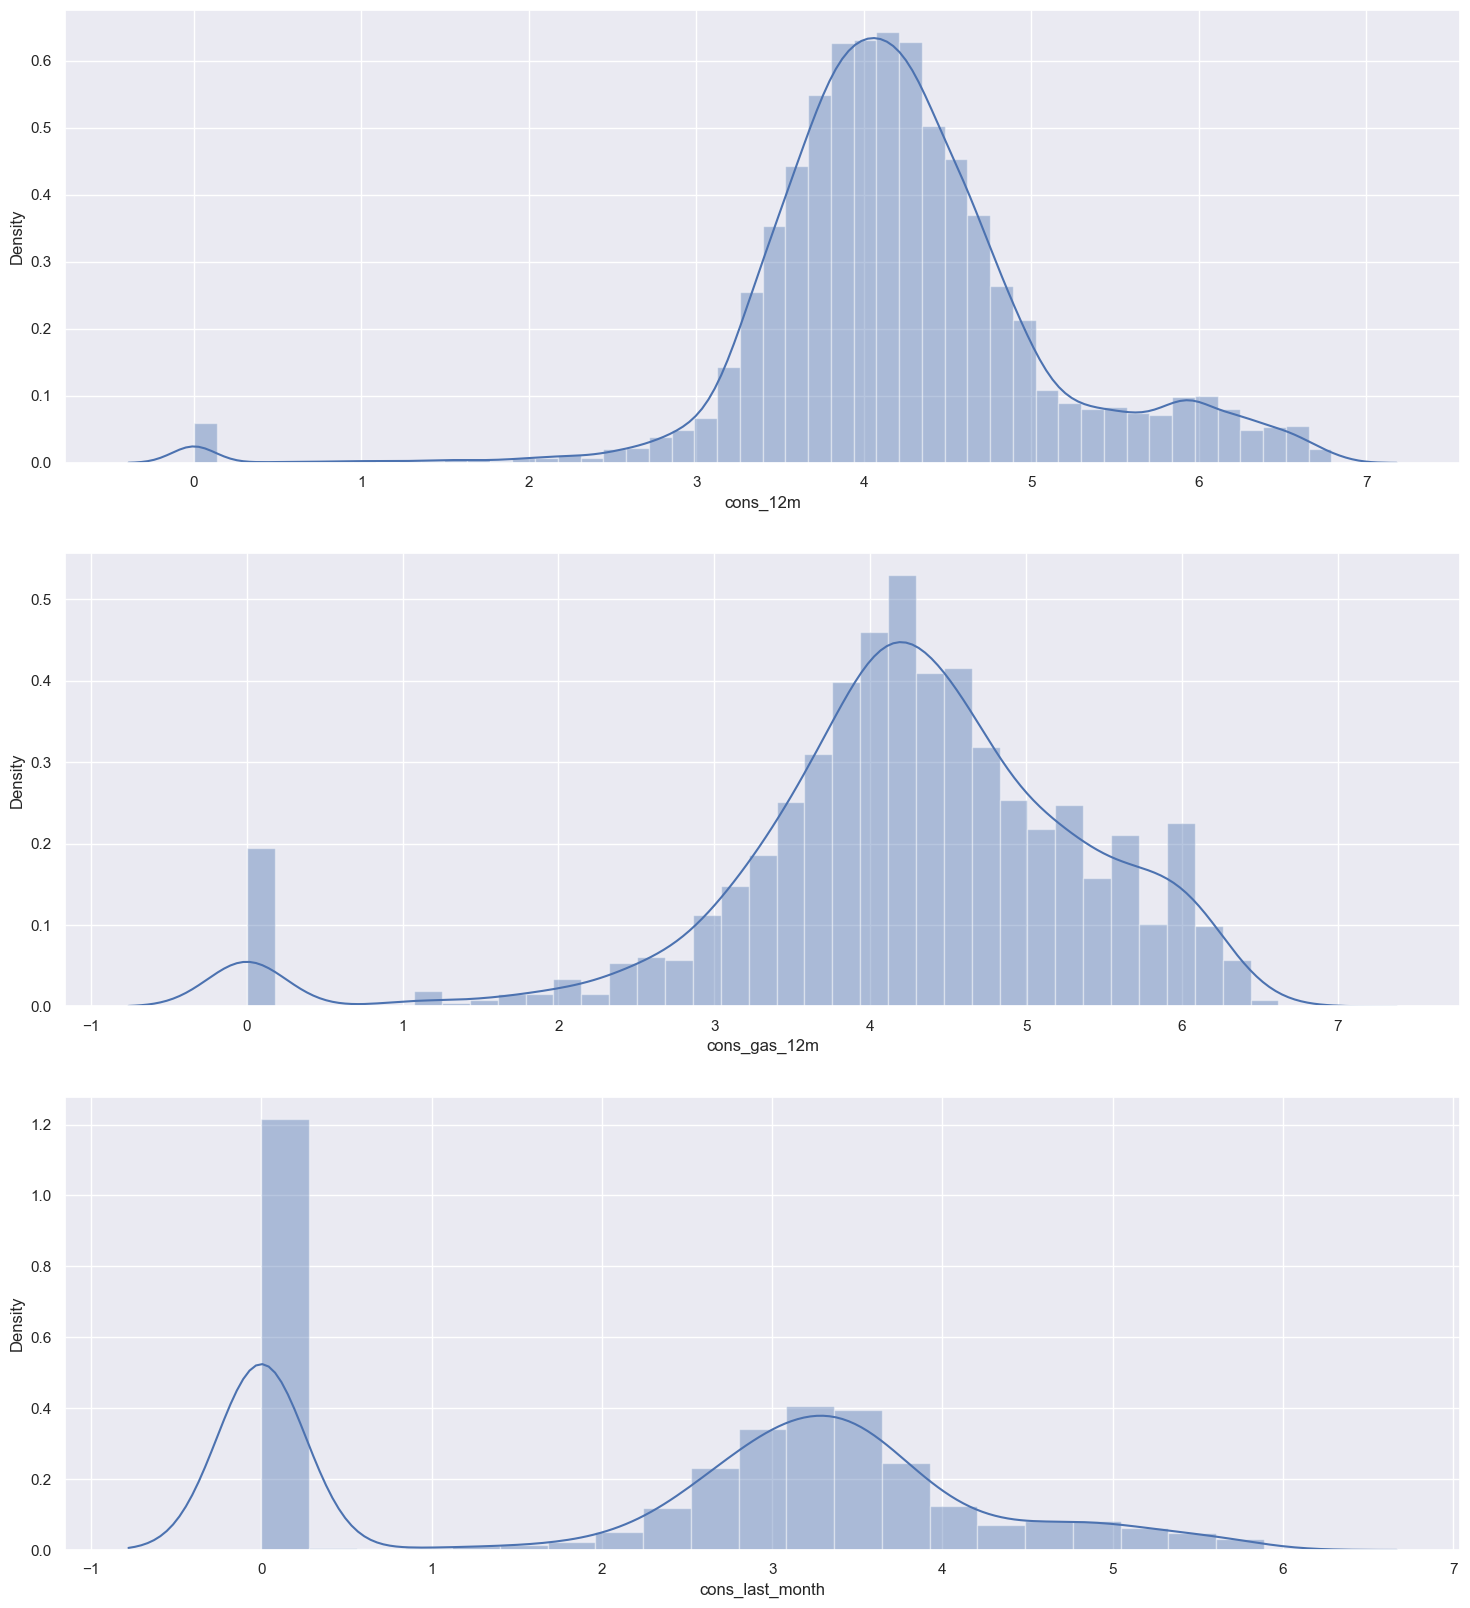

In [31]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 20))

sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.distplot((df["cons_last_month"].dropna()), ax=axs[2])
plt.show()

In [32]:
correlation = df.drop("id",axis=1).corr()

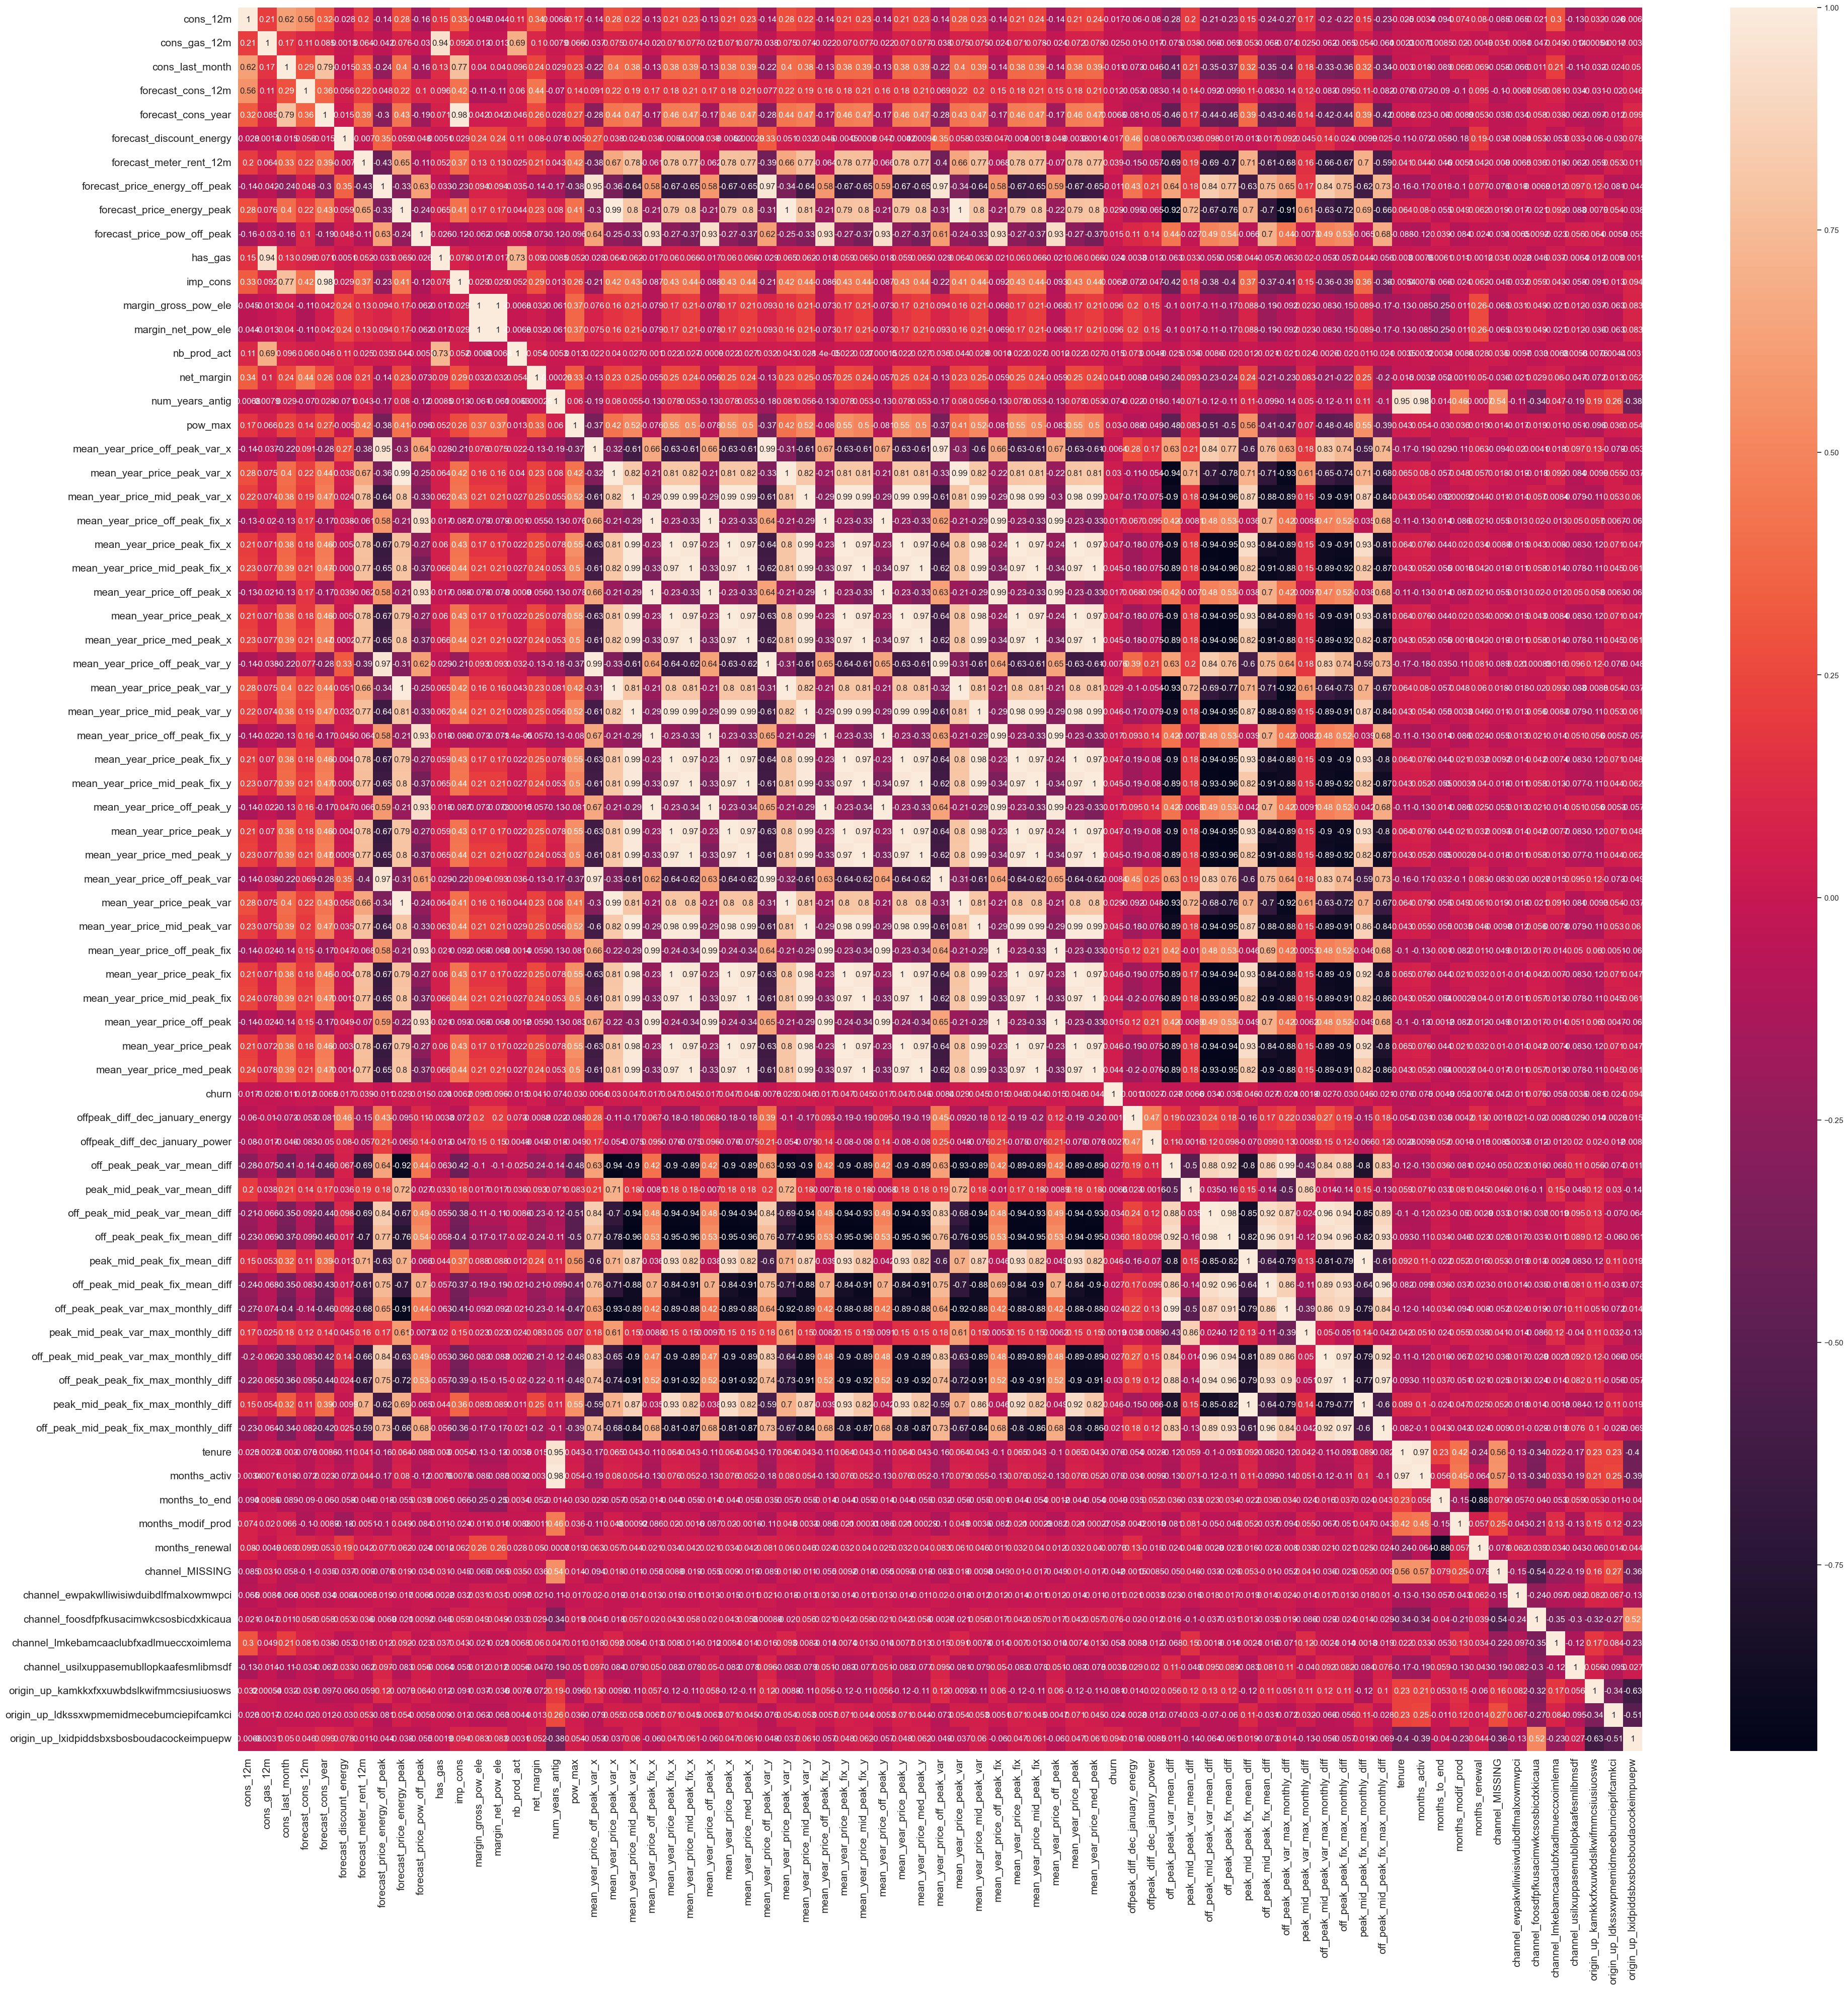

In [33]:
plt.figure(figsize=(45, 45))
sns.heatmap(
    correlation, 
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values, 
    annot=True, 
    annot_kws={'size': 12}
)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

I will remove two variables(num_years_antig and forecast_cons_year) which exhibit a high correlation with other independent features.

In [34]:
df = df.drop(columns=['num_years_antig', 'forecast_cons_year'])

# Modelling

In [35]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [36]:
train_df = df.copy()
y = df['churn']
X = df.drop(columns=['id', 'churn'])
print(X.shape)
print(y.shape)

(14605, 70)
(14605,)


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10953, 70)
(10953,)
(3652, 70)
(3652,)


In [38]:
model = RandomForestClassifier(
    n_estimators=1000
)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [39]:
y_pred = model.predict(X_test)
y_pred

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [40]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report

In [41]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score:- ", accuracy)
print("\n ----- Classification Report ----- \n")
print(classification_report(y_test, y_pred))

Accuracy score:-  0.9033406352683461

 ----- Classification Report ----- 

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      3279
           1       0.95      0.06      0.11       373

    accuracy                           0.90      3652
   macro avg       0.93      0.53      0.53      3652
weighted avg       0.91      0.90      0.86      3652



[[3278    1]
 [ 352   21]]


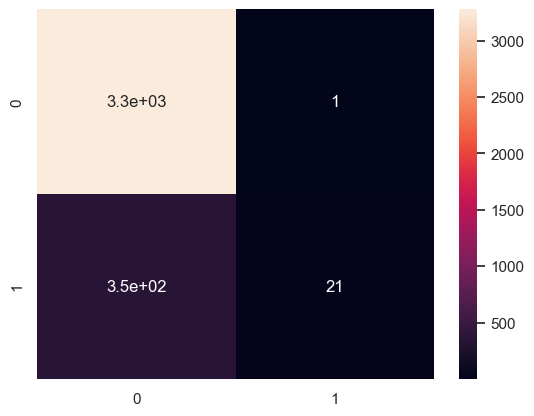

In [42]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

sns.heatmap(cm, annot=True)
plt.show()

# ROC/AUC

In [43]:
auc = roc_auc_score(y_test, y_pred)
print("AUC score:- ", auc)

AUC score:-  0.5279976485343812


# ROC Curve

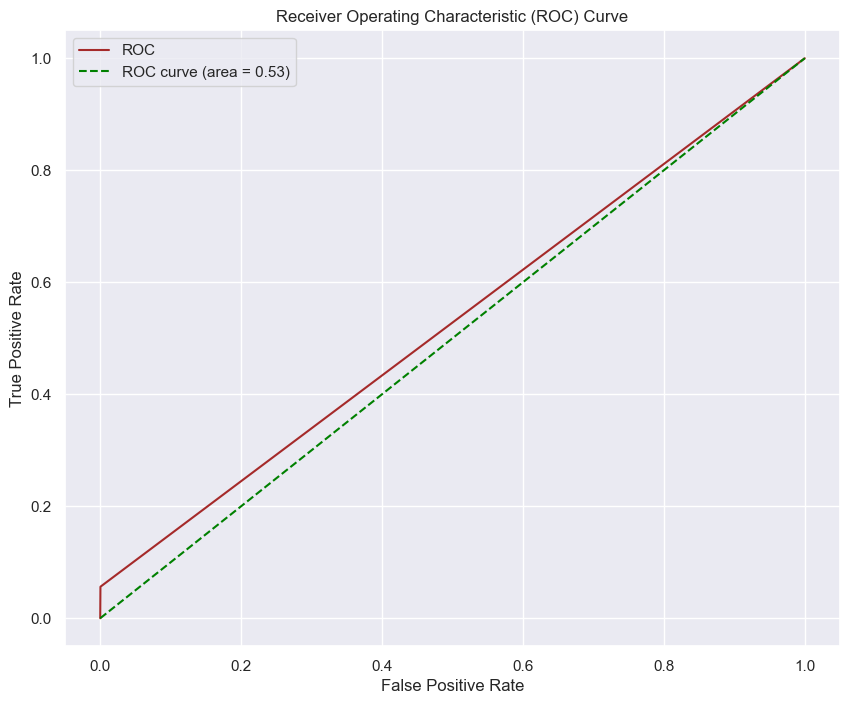

In [44]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, color='brown', label='ROC')
plt.plot([0, 1], [0, 1], color='green', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [45]:
# Applying 5-Fold Cross Validation
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train, y_train, cv = 5, scoring='accuracy')

print('Cross-validation scores:{}'.format(cv_scores))

Cross-validation scores:[0.90643542 0.91282519 0.90871748 0.90547945 0.90639269]


# We can summarize the cross-validation accuracy by calculating its mean.

In [46]:
print('Average cross-validation score: {:.4f}'.format(cv_scores.mean()))

Average cross-validation score: 0.9080


# Model Understanding

♦ Examining feature_importances is a quick and easy way to comprehend a model's findings. There are several ways to calculate feature importance, however using the Random Forest classifier, we are able to extract feature_importances using the built-in approach on the trained model. feature_importances reflect the importance of a feature within the prediction model. The amount of times each feature is used for splitting across all trees in the Random Forest scenario is represented by the feature importance.

In [47]:
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()

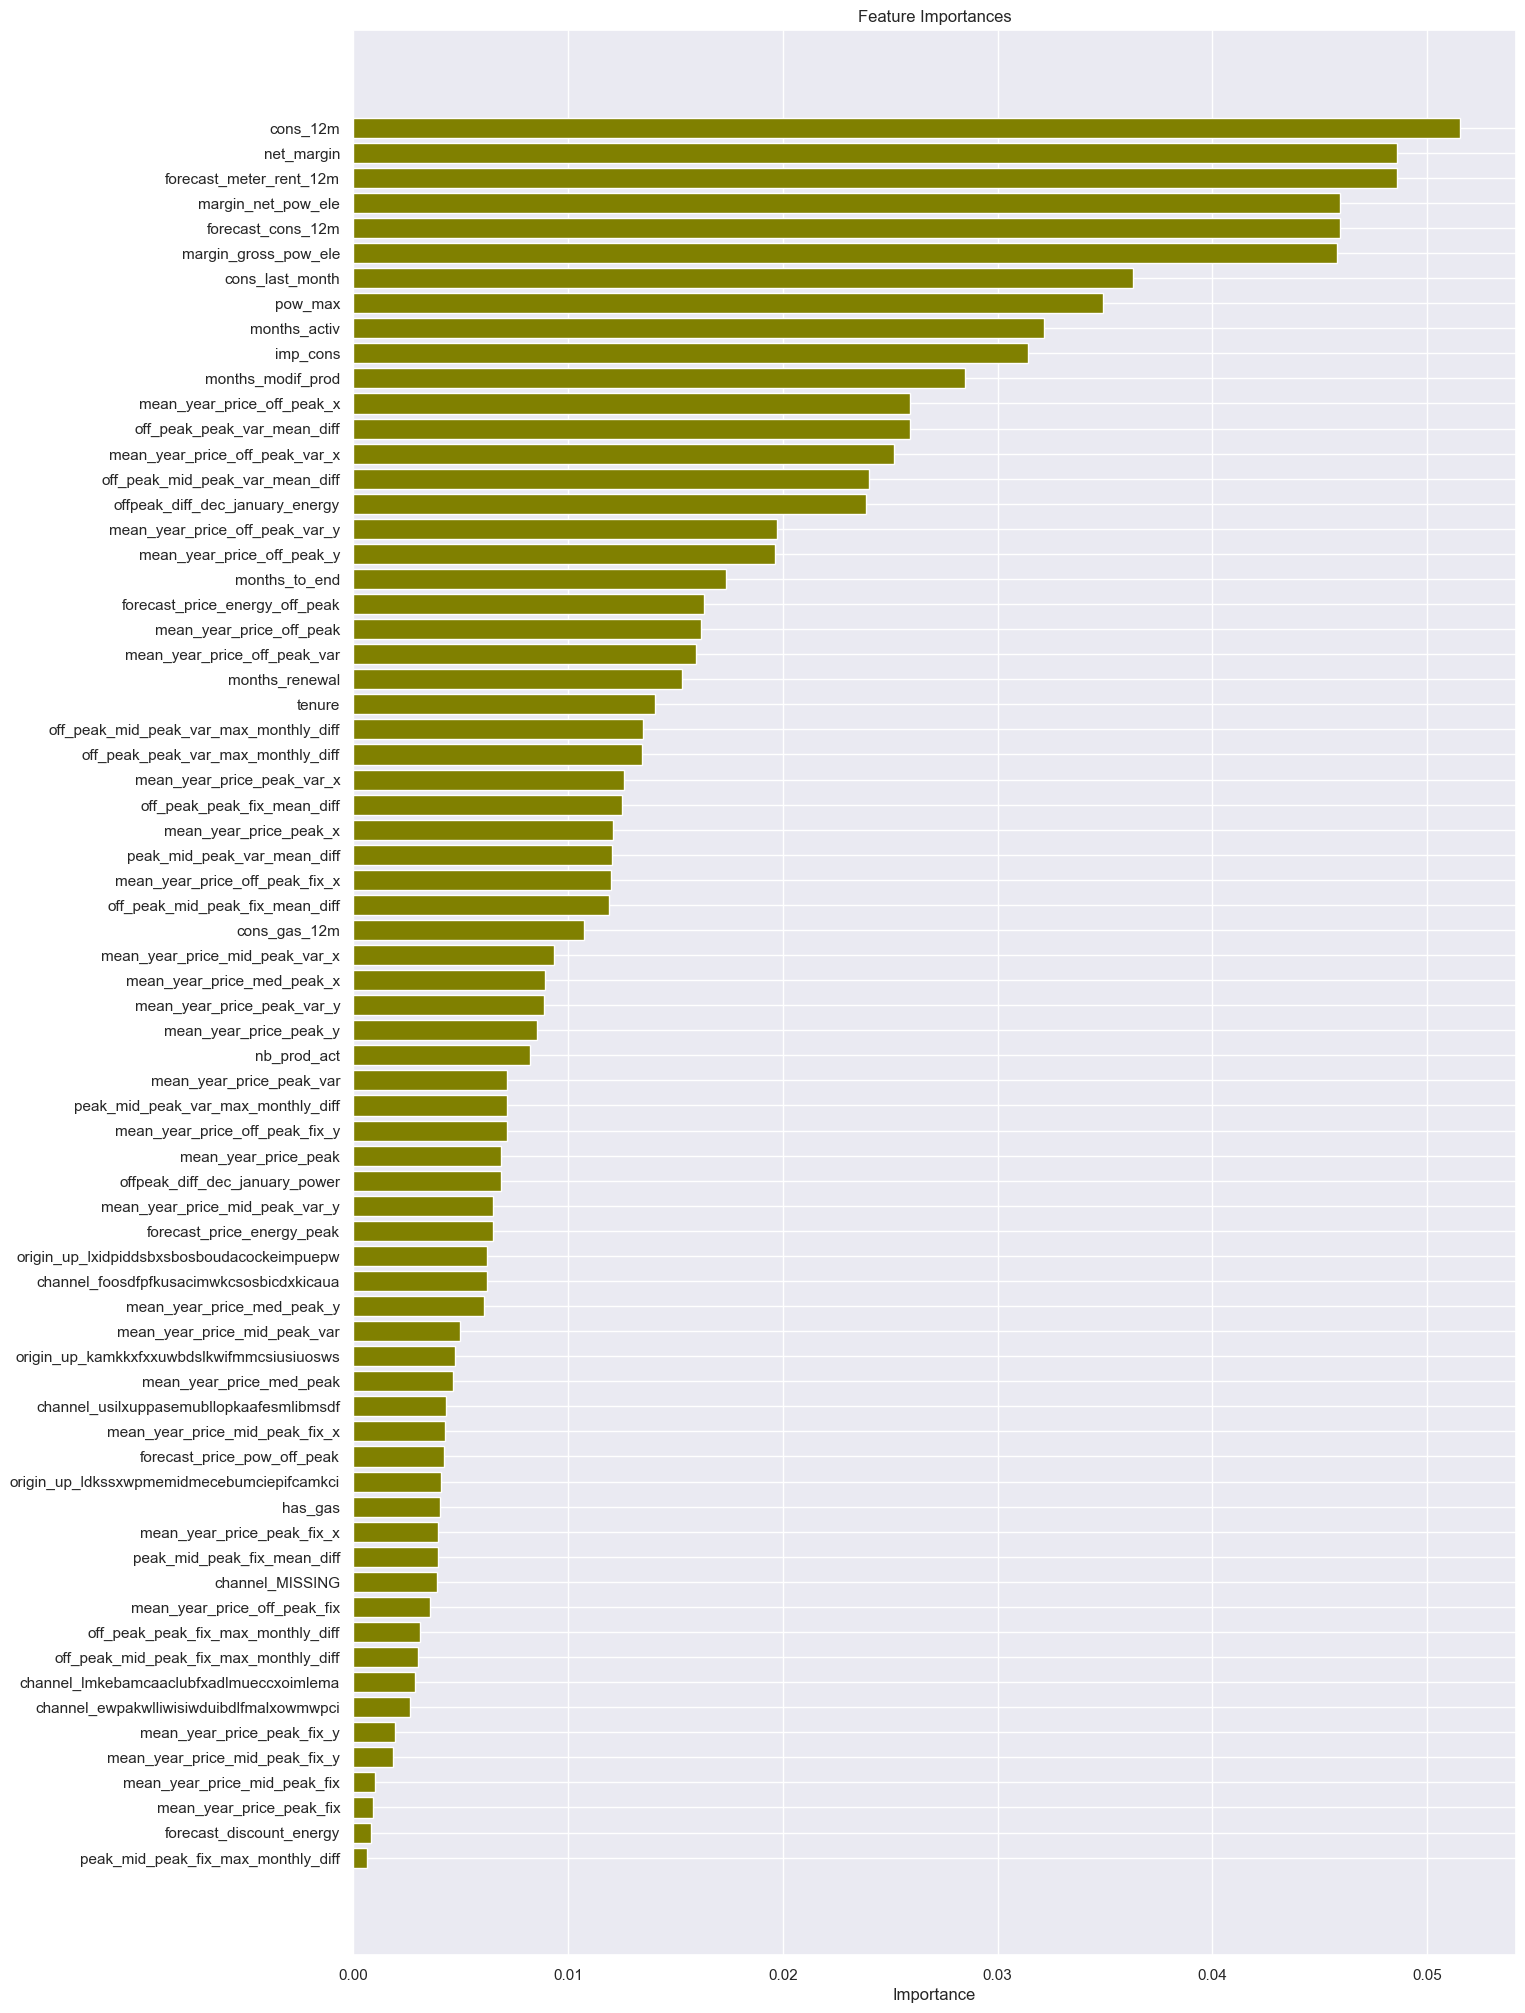

In [48]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='olive', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()

In [112]:
proba_predictions = model.predict_proba(X_test)
probabilities = proba_predictions[:, 1]

In [113]:
X_test = X_test.reset_index()
X_test.drop(columns='index', inplace=True)

In [114]:
X_test['churn'] = y_pred.tolist()
X_test['churn_probability'] = probabilities.tolist()
X_test.to_csv('C:\\Users\\ASUS\\OneDrive\\Desktop\\bcg\\predicted_data.csv')